In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
# Importing and inspecting CD file
df = pd.read_csv("data/aerodynamic_data_set_with_labels.csv")

df

rle       xup       yup     yxxup       xlo       ylo     yxxlo  \
0    0.007840  0.433200  0.062900 -0.424500  0.361800 -0.058900  0.706900   
1    0.008520  0.389880  0.069190 -0.466950  0.397980 -0.064790  0.777590   
2    0.007160  0.476520  0.056610 -0.382050  0.325620 -0.053010  0.636210   
3    0.007500  0.411540  0.066045 -0.488175  0.416070 -0.050065  0.600865   
4    0.008860  0.498180  0.053465 -0.403275  0.343710 -0.061845  0.742245   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.006655  0.422708  0.059018 -0.416872  0.348515 -0.054436  0.612463   
496  0.008015  0.509348  0.071598 -0.501772  0.420875 -0.066216  0.753843   
497  0.008695  0.379388  0.065308 -0.374422  0.384695 -0.048546  0.824533   
498  0.007335  0.466028  0.052728 -0.459322  0.312335 -0.060326  0.683153   
499  0.007675  0.357728  0.074743 -0.395647  0.366605 -0.063271  0.577118   

     alpha_te   beta_te        CL        CD        CM  
0   -0.112600  0.164600  0.808246  0.007262  0.121544  
1   -0.123860  0.148140  0.800081  0.018035  0.126753  
2   -0.101340  0.181060  0.779725  0.003612  0.110895  
3   -0.106970  0.139910  0.796090  0.012809  0.118196  
4   -0.129490  0.172830  0.764920  0.007443  0.107714  
..        ...       ...       ...       ...       ...  
495 -0.095622  0.174245  0.733211  0.004544  0.099914  
496 -0.118142  0.141325  0.828059  0.009883  0.142013  
497 -0.106882  0.190705  0.911397  0.018699  0.146730  
498 -0.129402  0.157785  0.711286  0.005625  0.098725  
499 -0.123772  0.166015  0.882524  0.028589  0.159709  

[500 rows x 12 columns]

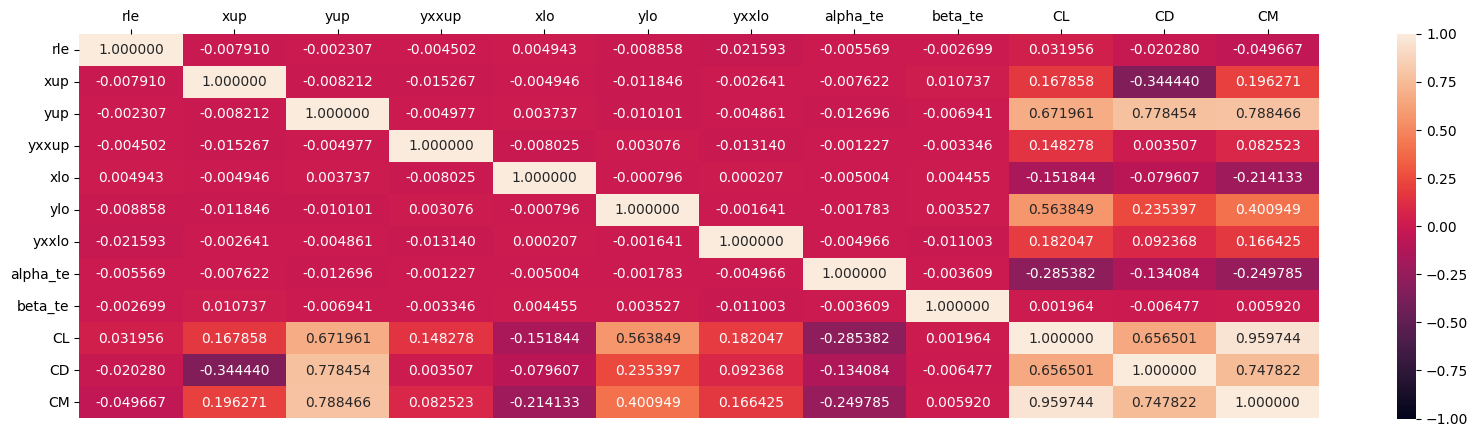

In [3]:
# Plot correlation heatmap
plt.figure(figsize=(20, 5))

# print(df.corr(method="pearson").to_latex)
sns.heatmap(df.corr(method="pearson"), annot=True, vmin=-1, vmax=1, fmt=".6f")

# Change the y-axis rotation
plt.yticks(rotation=0)

# Place x-axis on top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

# Change the x-tick values
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)

# CHange the y-tick values
plt.yticks(np.arange(0.5, len(df.columns), 1), df.columns)

# Export to svg & png
plt.savefig("./laporan/graph/case2_corr_heatmap.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case2_corr_heatmap.png", format = 'png', dpi=300, bbox_inches = 'tight')

# Show the plot
plt.show()

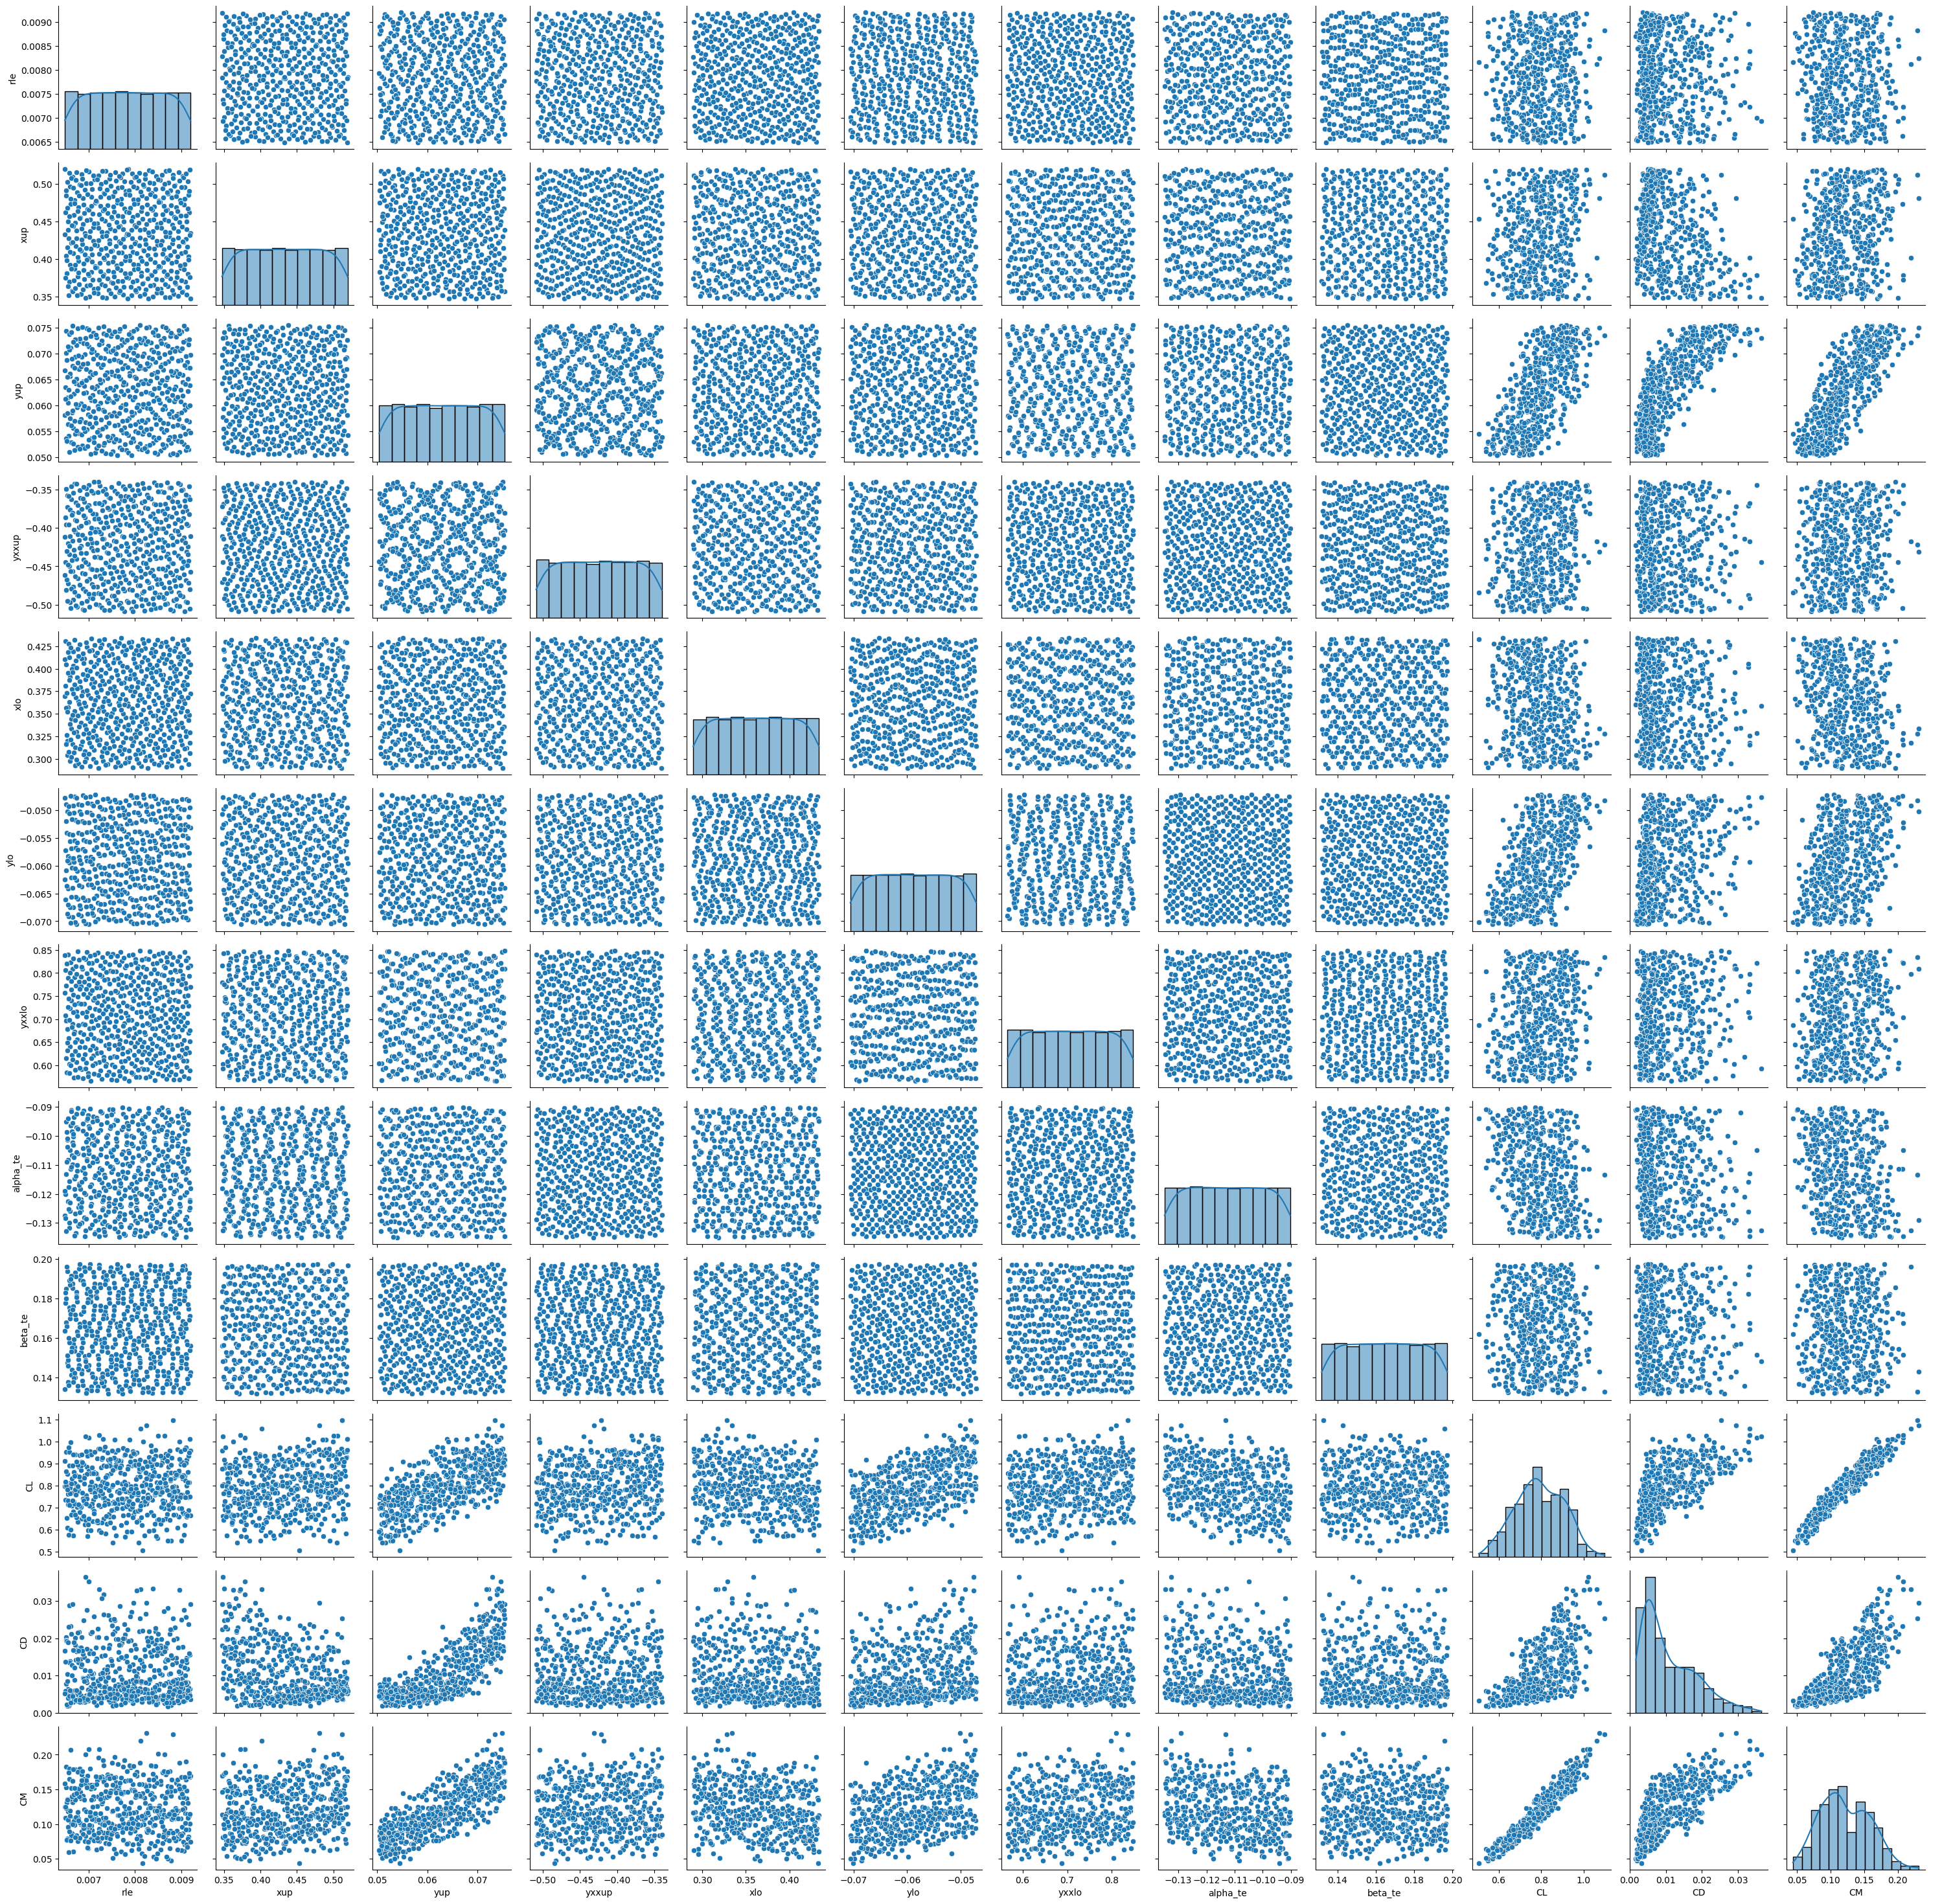

In [4]:
# Use PairGrid to visualize each column relation with others
g = sns.PairGrid(df)
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

plt.savefig("./laporan/graph/case2_data_dist.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case2_data_dist.png", format = 'png', dpi=300, bbox_inches = 'tight')

In [5]:
#Separating variables and response
x = df.drop(['CL', 'CD', 'CM'], axis=1)
y = df[['CL', 'CD', 'CM']]

In [6]:
# Normalizing inputs
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)

In [7]:
# Creating train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.2, random_state=1)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy as sp

# Create a class to for linear regression
class LinearRegression(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate number of data points
        self.training_n_ = X.shape[0]

        # Calculate number of variables
        self.p_ = X.shape[1]

        # Compute F by concaneating a column of ones to X
        F = np.c_[np.ones(self.training_n_), X]

        # Compute the estimation of coefficients
        self.beta_ = np.linalg.inv(F.T @ F) @ F.T @ y

        # Compute the RSS of beta
        self.RSS_ = np.sum((y - F @ self.beta_)**2)

        # Compute the RSE of beta
        self.RSE_ = np.sqrt(self.RSS_ / (self.training_n_ - self.p_ - 1))

        # Compute the estimation of variance of the model
        self.var_ = self.RSS_ / (self.training_n_ - self.p_ - 1)

        # Compute the estimation of variance of the coefficients
        self.beta_var_ = (self.var_ * np.linalg.inv(F.T @ F)).diagonal()
    
    def predict(self, X):
        # Calculate number of data points
        n = X.shape[0]

        # Compute F
        F = np.c_[np.ones(n), X]

        # Compute the prediction
        y_pred_CL = F @ self.beta_

        return y_pred_CL
    
    def evaluation_report(self, alpha=0.05):
        # Calculate standard error
        beta_se_ = np.sqrt(self.beta_var_)

        # Calculate t-statistic
        t_stat_ = self.beta_ / beta_se_

        # Calculate degree of freedom
        df_ = self.training_n_ - self.p_

        # Calculate p-value
        p_value_ = sp.stats.t.sf(np.abs(t_stat_), df_) * 2

        # Determine hypothesis test result
        hypothesis_test_result_ = np.where(p_value_ < alpha, 'Reject H0', 'Do Not Reject H0')

        # Create a dataframe to store the result
        result = pd.DataFrame({
            "Beta": self.beta_,
            "Standard Error": beta_se_,
            "t-statistic": t_stat_,
            "p-value": p_value_,
            "Hypothesis Test Result": hypothesis_test_result_
        })

        return result

In [9]:
model = LinearRegression()

In [10]:
# fitting the model
model.fit(x_train,y_train["CM"])

In [11]:
# making y_pred_CL
y_pred_CL = model.predict(x_test)

In [12]:
# Model Evaluation
print("RMSE: ", np.sqrt(mean_squared_error(y_test["CM"], y_pred_CL)))
print("MAE: ", mean_absolute_error(y_test["CM"], y_pred_CL))

RMSE:  0.006614169804374717
MAE:  0.005038962362793398


In [13]:
model.RSE_

0.0057989707537654004

In [14]:
from sklearn.metrics import r2_score

# r2_score(y_test["CM"], y_pred_CL)

print(model.evaluation_report().to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &      Beta &  Standard Error &  t-statistic &        p-value & Hypothesis Test Result \\
\midrule
0 &  0.045960 &        0.001605 &    28.634104 &   5.149599e-98 &              Reject H0 \\
1 & -0.004924 &        0.001005 &    -4.899170 &   1.411907e-06 &              Reject H0 \\
2 &  0.026385 &        0.001006 &    26.219789 &   3.620143e-88 &              Reject H0 \\
3 &  0.100599 &        0.001002 &   100.431480 &  2.655315e-281 &              Reject H0 \\
4 &  0.010215 &        0.000998 &    10.232636 &   6.212311e-22 &              Reject H0 \\
5 & -0.026673 &        0.001010 &   -26.402278 &   6.382478e-89 &              Reject H0 \\
6 &  0.052365 &        0.001015 &    51.611323 &  1.240393e-176 &              Reject H0 \\
7 &  0.022564 &        0.000998 &    22.611134 &   5.382271e-73 &              Reject H0 \\
8 & -0.029863 &        0.000998 &   -29.929553 &  3.518305e-103 &              Reject H0 \\
9 &  0.000521 &        0.000993 &    

C:\Users\hafiz\AppData\Local\Temp\ipykernel_25764\3850866007.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(model.evaluation_report().to_latex())


In [15]:
# Import r2 score
from sklearn.metrics import r2_score

r_squared = r2_score(y_train["CM"], model.predict(x_train))
print("R-squared value: ", r_squared)

R-squared value:  0.9754015799918838


In [16]:
x.columns

Index(['rle', 'xup', 'yup', 'yxxup', 'xlo', 'ylo', 'yxxlo', 'alpha_te',
       'beta_te'],
      dtype='object')

In [17]:
model.beta_[1:]

array([-0.00492364,  0.02638466,  0.10059944,  0.01021529, -0.02667322,
        0.05236532,  0.02256352, -0.02986292,  0.00052132])

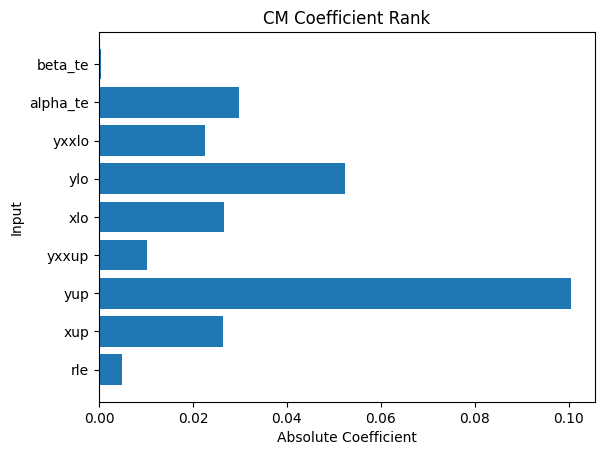

In [18]:
# Visualizing importance level through absolute value of beta
koefisien = pd.DataFrame({"Nama Kolom": x.columns, "Beta": model.beta_[1:]})

plt.barh(koefisien["Nama Kolom"], abs(koefisien["Beta"]))

plt.xlabel("Absolute Coefficient")
plt.ylabel("Input")

plt.title("CM Coefficient Rank")

plt.savefig("./laporan/graph/case2_cm_coef_rank.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case2_cm_coef_rank.png", format = 'png', dpi=300, bbox_inches = 'tight')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6c15a45-8d06-4acb-ae55-e8dab1b7dec4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>